Preparing dataset from C:/Users/anvithasubramani/Downloads/ecs763-coursework1 2/sentiment-dataset.csv...
Index(['Tweet ID', 'Sentiment', 'Tweet Text'], dtype='object')
Preparing training and test data...
After split, 33540 raw data, 30186 training samples, 3354 test samples
Number of features: 57847
Training Classifier...
Unique labels in test set: {'negative', 'positive'}
Done Training!
Training Classifier...
Unique labels in test set: {'positive', 'negative'}
Done Training!
Training Classifier...
Unique labels in test set: {'negative', 'positive'}
Done Training!
Training Classifier...
Unique labels in test set: {'positive', 'negative'}
Done Training!
Training Classifier...
Unique labels in test set: {'positive', 'negative'}
Done Training!
Training Classifier...
Unique labels in test set: {'negative', 'positive'}
Done Training!
Training Classifier...
Unique labels in test set: {'positive', 'negative'}
Done Training!
Training Classifier...
Unique labels in test set: {'positive', 'negat

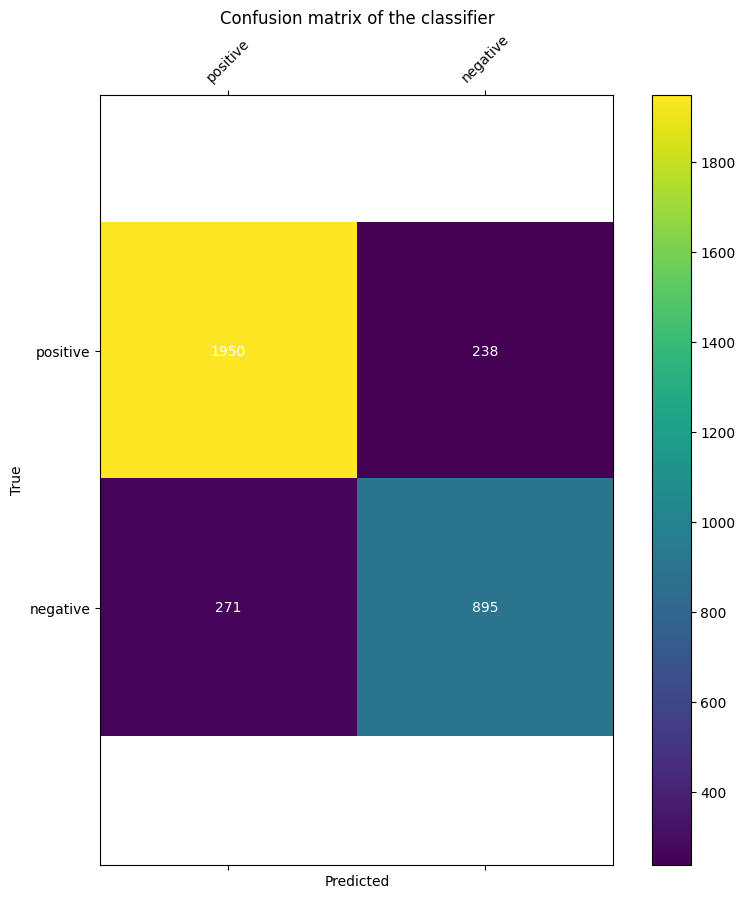

In [ ]:
import pandas as pd
import re
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Set the global variables
raw_data = []  # Data from the file
train_data = []  # Preprocessed training data
test_data = []  # Preprocessed test data
global_feature_dict = {}  # Global feature dictionary
# Set the global variables
raw_data = []  # Data from the file
train_data = []  # Preprocessed training data
test_data = []  # Preprocessed test data
global_feature_dict = {}  # Global feature dictionary

def load_data():
    """Load data from the specified CSV file and append it to raw_data."""
    global raw_data
    data_file_path = r"SourceFiles/sentiment-dataset.tsv"  # Correct file path
    
    # Load the data with proper column names
    dataset = pd.read_csv(data_file_path, sep = '\t', header=None, names=['Tweet ID', 'Sentiment', 'Tweet Text'])
    
    # Clean the column names to remove any leading/trailing spaces
    dataset.columns = dataset.columns.str.strip()
    
    # Print the column names for debugging
    print(dataset.columns)
    
    # Extract labels and tweet text, and append them to raw_data
    for index, row in dataset.iterrows():
        label = row['Sentiment']  # Ensure this matches the correct column name
        text = row['Tweet Text']
        raw_data.append((text, label))

def pre_process(text):
    """Return a list of tokens (words) after basic text preprocessing."""
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphabetic characters (optional, depending on task)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text by spaces
    return text.split()

def to_feature_vector(tokens):
    """Convert a list of tokens (words) into a feature vector (dictionary)."""
    feature_vector = {}
    for token in tokens:
        feature_vector[token] = 1  # Binary representation for presence of word
    return feature_vector

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    global train_data, test_data, global_feature_dict
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    
    # Train data processing
    for (text, label) in raw_data[:num_training_samples]:
        tokens = pre_process(text)  # Tokenize the tweet
        feature_vector = to_feature_vector(tokens)  # Convert to feature vector
        train_data.append((feature_vector, label))
        
        # Add features to the global dictionary
        for token in feature_vector:
            global_feature_dict[token] = global_feature_dict.get(token, 0) + 1
    
    # Test data processing
    for (text, label) in raw_data[num_training_samples:]:
        tokens = pre_process(text)
        feature_vector = to_feature_vector(tokens)
        test_data.append((feature_vector, label))

def cross_validate(dataset, folds=10):
    """Perform 10-fold cross-validation on the training data."""
    fold_size = len(dataset) // folds
    results = []
    
    # Perform 10-fold cross-validation
    for i in range(folds):
        val_data = dataset[i * fold_size:(i + 1) * fold_size]
        train_data = dataset[:i * fold_size] + dataset[(i + 1) * fold_size:]
        
        # Train the classifier
        classifier = train_classifier(train_data)
        
        # Test the classifier
        test_features = [item[0] for item in val_data]
        test_labels = [item[1] for item in val_data]
        predictions = predict_labels(test_features, classifier)
        
        # Calculate performance metrics
        precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='weighted')
        accuracy = accuracy_score(test_labels, predictions)
        print("Unique labels in test set:", set(test_labels))
        print("Done Training!")
        
        # Store the results
        results.append({'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy})
    
    # Calculate and print average performance across all folds
    avg_precision = np.mean([r['precision'] for r in results])
    avg_recall = np.mean([r['recall'] for r in results])
    avg_f1 = np.mean([r['f1'] for r in results])
    avg_accuracy = np.mean([r['accuracy'] for r in results])
    
    print("Cross-Validation Results:")
    print(f"Precision: {avg_precision:.3f}")
    print(f"Recall: {avg_recall:.3f}")
    print(f"F1 Score: {avg_f1:.3f}")
    print(f"Accuracy: {avg_accuracy:.3f}")
    
    return results

def train_classifier(data):
    """Train the classifier using LinearSVC."""
    print("Training Classifier...")
    classifier = SklearnClassifier(LinearSVC())
    classifier.train(data)  # Train the classifier with the data
    return classifier

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

def confusion_matrix_heatmap(y_test, preds, labels):
    """Plot a confusion matrix."""
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    b, t = plt.ylim()  # Fix bug with labels being cut off
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

# MAIN

# Load and prepare the data
print(f"Preparing dataset from C:/Users/anvithasubramani/Downloads/ecs763-coursework1 2/sentiment-dataset.csv...")
load_data()

# Split the data into training and test sets (80%/20%)
print("Preparing training and test data...")
split_and_preprocess_data(0.9)

# Print the dataset stats
print(f"After split, {len(raw_data)} raw data, {len(train_data)} training samples, {len(test_data)} test samples")
print(f"Number of features: {len(global_feature_dict)}")

# Perform cross-validation
cross_validate(train_data, 10)

# Train the classifier and evaluate on the test set
classifier = train_classifier(train_data)
test_features = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]
predictions = predict_labels(test_features, classifier)

# Evaluate and print performance
final_scores = precision_recall_fscore_support(test_labels, predictions, average='weighted')
print(f"Precision: {final_scores[0]:.3f}\nRecall: {final_scores[1]:.3f}\nF1 Score: {final_scores[2]:.3f}")

# Perform error analysis with confusion matrix
confusion_matrix_heatmap(test_labels, predictions, labels=['positive', 'negative'])

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack
import nltk
import numpy as np

# Download the packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('opinion_lexicon')

# Set global variables
raw_data = []  # Data from the file
train_data = []  # Preprocessed training data
test_data = []  # Preprocessed test data
global_feature_dict = {}  # Global feature dictionary

# Load the data
def load_data():
    """Load data from the specified CSV file and append it to raw_data."""
    global raw_data
    data_file_path = r"SourceFiles/sentiment-dataset.csv"  # Correct file path
    
    dataset = pd.read_csv(data_file_path, header=None, sep='\t', names=['Tweet ID', 'Sentiment', 'Tweet Text'])
    dataset.columns = dataset.columns.str.strip()
    
    for index, row in dataset.iterrows():
        label = row['Sentiment']
        text = row['Tweet Text']
        raw_data.append((text, label))

# Preprocessing the data
def pre_process(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@[\w]+|#\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Convert tokens to feature vectors
def to_feature_vector(tokens):
    return {token: 1 for token in tokens}

# Extract stylistic features
def extract_stylistic_features(text):
    length = len(text.split())
    punctuation_count = sum([1 for char in text if char in ['.', '!', '?']])
    return [length, punctuation_count]

# Lexicon-based features
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def lexicon_features(text):
    words = set(text.split())
    positive_count = len(words & positive_words)
    negative_count = len(words & negative_words)
    return [positive_count, negative_count]

# TF-IDF feature extraction
def extract_tfidf_features(raw_data):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), sublinear_tf=True, max_df=0.9, min_df=3)
    X_tfidf = tfidf_vectorizer.fit_transform([text for text, _ in raw_data])
    return X_tfidf, tfidf_vectorizer

# Prepare combined features
def prepare_combined_features(raw_data):
    X_tfidf, tfidf_vectorizer = extract_tfidf_features(raw_data)
    numeric_feats = np.array([
        extract_stylistic_features(text) + lexicon_features(text)
        for text, _ in raw_data
    ])
    X_combined = hstack([X_tfidf, numeric_feats])
    y = np.array([label for _, label in raw_data])
    return X_combined, y, tfidf_vectorizer

# Train and evaluate model
def train_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    param_grid = {
        'C': [1, 2, 5, 10],
        'class_weight': [None, 'balanced'],
        'max_iter': [10000]
    }
    grid = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best parameters:", grid.best_params_)
    
    clf = LinearSVC(**grid.best_params_)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")
    return clf

# MAIN EXECUTION
load_data()
X_combined, y, tfidf_vectorizer = prepare_combined_features(raw_data)
final_model = train_evaluate_model(X_combined, y)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anvithasubramani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anvithasubramani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anvithasubramani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anvithasubramani/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/anvithasubramani/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
/Users/anvithasubramani/Documents/Source/Assignment1/Q4/SourceFiles/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Use

Best parameters: {'C': 1, 'class_weight': None, 'max_iter': 10000}
Precision: 0.863, Recall: 0.864, F1 Score: 0.863
